In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from skimage.io import imshow
from pathlib import Path
import pandas as pd
import time
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.utils.vis_utils import *
import keras
import importlib
import pydot
from IPython.display import Image 

In [19]:
dataset_root = Path('../MURA-v1.1')

In [20]:
df = pd.read_csv(dataset_root/'train_image_paths.csv', header=None, names=['filename'])
df.head()

,filename
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...


In [21]:
df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
df.head()

,filename,class
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,positive
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,positive


In [22]:
def generate_df(dataset_root, csv_name):
    df = pd.read_csv(dataset_root/csv_name, header=None, names=['filename'])
    df['class'] = (df.filename
               .str.extract('study.*_(positive|negative)'))
    return df

In [34]:
batch_size=32
img_height=224
img_width=224
nb_epochs = 10

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1. / 255,
                                                          shear_range=0.2,
                                                          zoom_range=0.2,
                                                          rotation_range = 30, 
                                                          fill_mode = "nearest", 
                                                          width_shift_range = 0.1, 
                                                          height_shift_range = 0.1,
                                                          horizontal_flip=True,
                                                          validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    generate_df(dataset_root, 'train_image_paths.csv'),
    directory=dataset_root.parent,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    subset='training') # set as training data

validation_generator = datagen.flow_from_dataframe(
    generate_df(dataset_root, 'train_image_paths.csv'), # same directory as training data
    directory=dataset_root.parent,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

test_generator = datagen.flow_from_dataframe(generate_df(dataset_root, 'valid_image_paths.csv'),
    directory=dataset_root.parent,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 33128 images belonging to 2 classes.
Found 3680 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.


In [25]:
def plotAccuracyLoss(someHistory):
    plt.style.use('dark_background')
    plt.rcParams['font.size'] = 14
    plt.figure(1, figsize = (15,8)) 
    plt.subplot(221)  
    plt.plot(someHistory.history['acc'])  
    plt.plot(someHistory.history['val_acc'])  
    plt.title('Model Accuracy')  
    plt.ylabel('Accuracy')  
    plt.xlabel('Epochs')  
    plt.legend(['train', 'valid'], loc='upper left')

    plt.subplot(222)  
    plt.plot(someHistory.history['loss'])  
    plt.plot(someHistory.history['val_loss'])  
    plt.title('Model Loss')  
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'valid'], loc='upper left')

    plt.show()

In [26]:
# Early stopping & checkpointing the best model
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 4)
cb_checkpointer = ModelCheckpoint(filepath = 'output/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [39]:
modelCNN1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(img_height, img_width,3)),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3),activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

modelCNN1.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
modelCNN1.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
dropout_8 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 760384)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                48664640  
__________

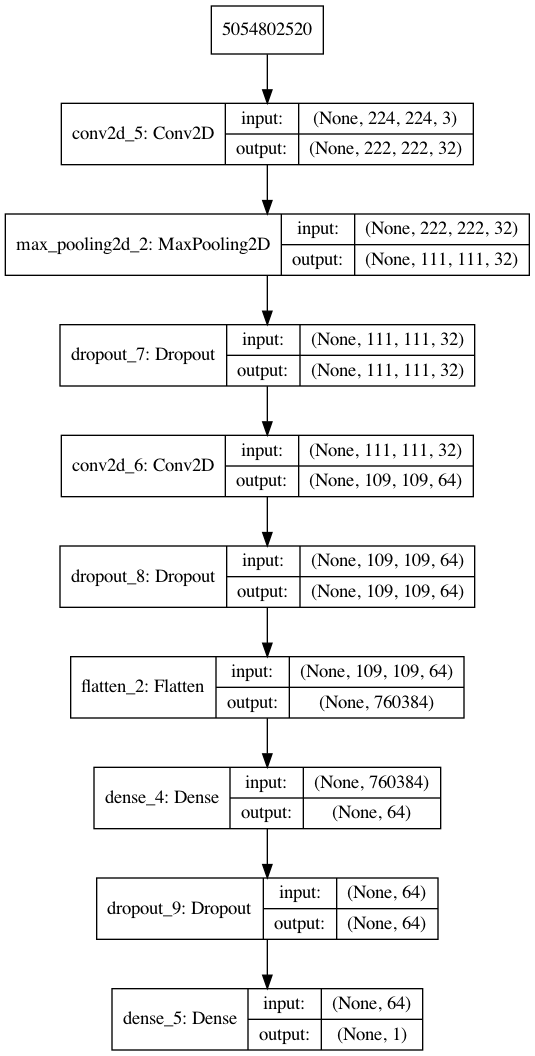

In [41]:
#Print the network architecture diagram
importlib.reload(keras.utils.vis_utils)
plot_model(modelCNN1, to_file='output/simple_cnn.png', show_shapes=True)
Image('output/simple_cnn.png')

In [29]:
STEP_SIZE_TRAIN=train_generator.samples//batch_size
STEP_SIZE_VALID=validation_generator.samples//batch_size

t_start = time.time()

historyCNN1 = modelCNN1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=nb_epochs,
                    workers=20, #???? # Maximum number of processes
                    callbacks=[cb_checkpointer, cb_early_stopper],
                    use_multiprocessing=True # use process based threading.
)


Epoch 1/10
1036/1036 [==============================] - 4854s 5s/step - loss: 5.5170 - acc: 0.6568 - val_loss: 15.4304 - val_acc: 0.0427
Epoch 2/10
1036/1036 [==============================] - 3413s 3s/step - loss: 5.5197 - acc: 0.6574 - val_loss: 15.4304 - val_acc: 0.0427
Epoch 3/10
1036/1036 [==============================] - 4514s 4s/step - loss: 5.5241 - acc: 0.6574 - val_loss: 15.4304 - val_acc: 0.0427
Epoch 4/10
1036/1036 [==============================] - 7018s 7s/step - loss: 5.5226 - acc: 0.6574 - val_loss: 15.4304 - val_acc: 0.0427
Epoch 5/10
1036/1036 [==============================] - 8542s 8s/step - loss: 5.5211 - acc: 0.6574 - val_loss: 15.4304 - val_acc: 0.0427


In [31]:
modelCNN1.metrics_names

['loss', 'acc']

In [35]:
modelCNN1.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TRAIN)

[7.7121960639953615, 0.5214263]

In [36]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 27.406310238374605 hours


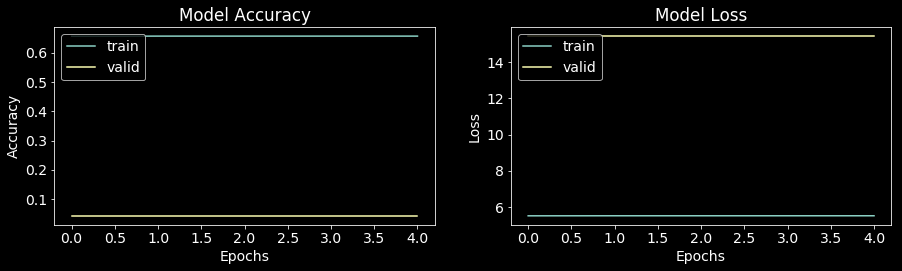

In [37]:
plotAccuracyLoss(historyCNN1)